In [2]:
from math import gcd
from itertools import combinations
from functools import reduce

import numpy as np

class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        """
        Initialize the MarkovChain instance.
        Parameters
        ----------
        transition_matrix: 2-D array
            A 2-D array representing the probabilities of change of
            state in the Markov Chain.
        states: 1-D array
            An array representing the states of the Markov Chain. It
            needs to be in the same order as transition_matrix.
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}


    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time
        instance.
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
            self.states,
            p=self.transition_matrix[self.index_dict[current_state], :])


    def generate_states(self, current_state, no=10):
        """
        Generates the next states of the system.
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states


    def is_accessible(self, i_state, f_state, check_up_to_depth=1000):
        """
        Check if state f_state is accessible from i_state.
        Parameters
        ----------
        i_state: str
            The state from which the accessibility needs to be checked.
        f_state: str
            The state to which accessibility needs to be checked.
        """
        counter = 0
        reachable_states = [self.index_dict[i_state]]
        for state in reachable_states:
            if counter == check_up_to_depth:
                break
            if state == self.index_dict[f_state]:
                return True
            else:
                reachable_states.extend(np.nonzero(self.transition_matrix[state, :])[0])
            counter = counter + 1
        return False


    def is_irreducible(self):
        """
        Check if the Markov Chain is irreducible.
        """
        for (i, j) in combinations(self.states, 2):
            if not self.is_accessible(i, j):
                return False
        return True


    def get_period(self, state, max_number_stps = 50, max_number_trls = 100):
        """
        Returns the period of the state in the Markov Chain.
        Parameters
        ----------
        state: str
            The state for which the period needs to be computed.
        """
        initial_state = state
        max_number_steps = max_number_stps
        max_number_trials = max_number_trls
        periodic_lengths = []
        a= []

        for i in range(1, max_number_steps+1):
            for j in range(max_number_trials):
                last_states_chain = self.generate_states(current_state=initial_state, no=i)[-1]
                if last_states_chain == initial_state:
                    periodic_lengths.append(i)
                    break

        if len(periodic_lengths) >0:
            a = reduce(gcd, periodic_lengths)
            return a


    def is_aperiodic(self):
        """
        Checks if the Markov Chain is aperiodic.
        """
        periods = [self.get_period(state) for state in self.states]
        for period in periods:
            if period != 1:
                return False
        return True


    def is_transient(self, state):
        """
        Checks if a state is transient or not.
        Parameters
        ----------
        state: str
            The state for which the transient property needs to be checked.
        """
        if np.all(self.transition_matrix[~self.index_dict[state], self.index_dict[state]] == 0):
            return True
        else:
            return False

    def is_absorbing(self, state):
        """
        Checks if the given state is absorbing.
        Parameters
        ----------
        state: str
        The state for which we need to check whether it's absorbing
        or not.
        """
        state_index = self.index_dict[state]
        if self.transition_matrix[state_index, state_index] == 1:
            return True
        else:
            return False

In [3]:
import numpy as np


class MultinomialHMM:
    def __init__(self, num_states, observation_states, prior_probabilities, transition_matrix, emission_probabilities):
        """
        Initialize Hidden Markov Model
        Parameters
        -----------
        num_states: int
        Number of states of latent variable
        observation_states: 1-D array
        An array representing the set of all observations
        prior_probabilities: 1-D array
        An array representing the prior probabilities of all the states
        of latent variable
        transition_matrix: 2-D array
        A matrix representing the transition probabilities of change of
        state of latent variable
        emission_probabilities: 2-D array
        A matrix representing the probability of a given observation
        given the state of the latent variable
        """
        # As latent variables form a Markov chain, we can use
        # use the previous defined MarkovChain class to create it
        self.latent_variable_markov_chain = MarkovChain(transition_matrix=transition_matrix, states=['z{index}'.format(index=index) for index in range(num_states)])
        self.observation_states = observation_states
        self.prior_probabilities = np.atleast_1d(prior_probabilities)
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.emission_probabilities = np.atleast_2d(emission_probabilities)

    def observation_from_state(self, state):
        """
        Generate observation for a given state in accordance with
        the emission probabilities
     
        Parameters
        ----------
        state: int
        Index of the current state
        """
        state_index = self.latent_variable_markov_chain.index_dict[state]
        return np.random.choice(self.observation_states, p=self.emission_probabilities[state_index, :])

    def generate_samples(self, no=10):
       """
       Generate samples from the hidden Markov model
       Parameters
       ----------
       no: int
       Number of samples to be drawn
     
       Returns
       -------
       observations: 1-D array
       An array of sequence of observations
       state_sequence: 1-D array
       An array of sequence of states
       """
       observations = []
       state_sequence = []
       initial_state = np.random.choice(self.latent_variable_markov_chain.states, p=self.prior_probabilities)
       state_sequence.append(initial_state)
       observations.append(self.observation_from_state(initial_state))
       current_state = initial_state
       for i in range(2, no):
         next_state = self.latent_variable_markov_chain.next_state(current_state)
         state_sequence.append(next_state)
         observations.append(self.observation_from_state(next_state))
         current_state = next_state
       return observations, state_sequence

**Generating an observation sequence**

For a given HMM parameterized by {A, π, Φ}, we can generate a sequence of observations, {$x_1$, ..., $x_N$}, using the following steps:

1. Set n = 1
2. Choose an initial state of the latent variable, $z1$, according to the prior distribution, π
3. Choose an observation, $x_1$, for the given value of $z_1$, by sampling the emission-probability distribution governed by Φ
4. Transit to the next state of the latent variable, $z_{n+1}$, according to the state-transition probability matrix, A
5. Set $n = n + 1$ and repeat step 3 if $n$ ≤ $N$, otherwise terminate

In [4]:
coin_hmm = MultinomialHMM(num_states=2,
                          observation_states=['H', 'T'],
                          prior_probabilities=[0.5, 0.5],
                          transition_matrix=[[0.5, 0.5], [0.5, 0.5]],
                          emission_probabilities=[[0.8, 0.2], [0.3, 0.7]])

In [6]:
coin_hmm.generate_samples()

(['H', 'H', 'T', 'H', 'H', 'H', 'H', 'T', 'H'],
 ['z0', 'z0', 'z1', 'z0', 'z0', 'z0', 'z1', 'z1', 'z0'])

In [ ]:
!pip install hmmlearn

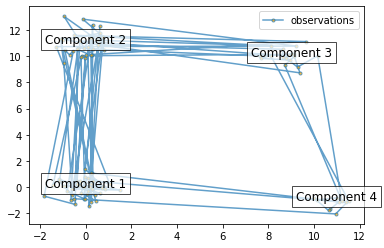

In [11]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import matplotlib.pyplot as plt

startprob = np.array([0.6, 0.3, 0.1, 0.0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.7, 0.2, 0.0, 0.1],
                     [0.3, 0.5, 0.2, 0.0],
                     [0.0, 0.3, 0.5, 0.2],
                     [0.2, 0.0, 0.2, 0.6]])
# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 11.0],
                  [9.0, 10.0],
                  [11.0, -1.0]])
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))

# Build an HMM instance and set parameters
model = GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

X, state_sequence = model.sample(n_samples=100)

plt.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)
for i, m in enumerate(means):
    plt.text(m[0], m[1], 'Component %i' % (i + 1),
             size=12, horizontalalignment='center',
             bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()